In [1]:
# uncomment the line below to make matplotlib plots dynamic
#%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
# this ensures that all C output is redirected to the Jupyter output box
%load_ext wurlitzer

from xspec import *

##Simultaneous Fitting

XSPEC has the very useful facility of allowing models to be fitted simultaneously to more than one data file. It is even possible to group files together and to fit different models simultaneously. Reasons for fitting in this manner include:

    The same target is observed at several epochs but, although the source stays constant, the response matrix has changed. When this happens, the data files cannot be added together; they have to be fitted separately. Fitting the data files simultaneously yields tighter constraints.
    The same target is observed with different instruments. All the instruments on Suzaku, for example, observe in the same direction simultaneously. As far as XSPEC is concerned, this is just like the previous case: two data files with two responses fitted simultaneously with the same model.
    Different targets are observed, but the user wants to fit the same model to each data file with some parameters shared and some allowed to vary separately. For example, if we have a series of spectra from a variable AGN, we might want to fit them simultaneously with a model that has the same, common photon index but separately vary the normalization and absorption.

Other scenarios are possible--the important thing is to recognize the flexibility of XSPEC in this regard.

As an example we will look at a case of fitting the same model to two different data files but where not all the parameters are identical. Again, this is an older dataset that provides a simpler illustration than more modern data. The massive X-ray binary Centaurus X-3 was observed with the LAC on Ginga in 1989. Its flux level before eclipse was much lower than the level after eclipse. Here, we'll use XSPEC to see whether spectra from these two phases can be fitted with the same model, which differs only in the amount of absorption. The spectra and corresponding response matrices were obtained from the HEASARC and are available from https://heasarc.gsfc.nasa.gov/docs/xanadu/xspec/walkthrough.tar.gz

This kind of fitting relies on introducing an extra dimension, the group, to the indexing of the data files. The files in each group share the same model but not necessarily the same parameter values, which may be shared as common to all the groups or varied separately from group to group. Although each group may contain more than one file, there is only one file in each of the two groups in this example. Groups are specified with the data command, with the group number preceding the file number, like this: 

In [2]:
%cd data
AllData("1:1 losum 2:2 hisum")

/Users/karnaud/Jupyter-notebooks/data

2 spectra  in use
 
Spectral Data File: losum.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.401e+02 +/- 3.549e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-48
  Telescope: GINGA Instrument: LAC  Channel Type: PHA
  Exposure Time: 1 sec
 Using fit statistic: chi
 Using Response (RMF) File            ginga_lac.rsp for Source 1

Spectral Data File: hisum.pha  Spectrum 2
Net count rate (cts/s) for Spectrum:2  1.371e+03 +/- 3.123e+00
 Assigned to Data Group 2 and Plot Group 2
  Noticed Channels:  1-48
  Telescope: GINGA Instrument: LAC  Channel Type: PHA
  Exposure Time: 1 sec
 Using fit statistic: chi
 Using Response (RMF) File            ginga_lac.rsp for Source 1



Here, the first group makes up the file losum.pha, which contains the spectrum of all the low, pre-eclipse emission. The second group makes up the second file, hisum.pha, which contains all the high, post-eclipse emission. Note that file number is "absolute" in the sense that it is independent of group number. Thus, if there were three files in each of the two groups (lo1.pha, lo2.pha, lo3.pha, hi1.pha, hi2.pha, and hi3.pha, say), rather than one, the six files would be specified as "1:1 lo1 1:2 lo2 1:3 lo3 2:4 hi1 2:5 hi2 2:6 hi3". The ignore method works on file number, and does not take group number into account. So, to ignore channels 1-3 and 37-48 of both files: 

In [3]:
AllData.ignore("1-3 37-48")

     3 channels (1,3) ignored in spectrum #     1
     3 channels (1,3) ignored in spectrum #     2
    12 channels (37,48) ignored in spectrum #     1
    12 channels (37,48) ignored in spectrum #     2



The model we'll use at first to fit the two files is an absorbed power law with a high-energy cut-off: 

In [4]:
Model("phabs * highecut(pow)")


Model phabs<1>*highecut<2>*powerlaw<3> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
                           Data group: 1
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   highecut   cutoffE    keV      10.0000      +/-  0.0          
   3    2   highecut   foldE      keV      15.0000      +/-  0.0          
   4    3   powerlaw   PhoIndex            1.00000      +/-  0.0          
   5    3   powerlaw   norm                1.00000      +/-  0.0          
                           Data group: 2
   6    1   phabs      nH         10^22    1.00000      = p1
   7    2   highecut   cutoffE    keV      10.0000      = p2
   8    2   highecut   foldE      keV      15.0000      = p3
   9    3   powerlaw   PhoIndex            1.00000      = p4
  10    3   powerlaw   norm                1.00000      = p5
________________________________________________________________________


Fit statistic  : Chi-Squared         

Notice how the summary of the model, displayed immediately above, is different now that we have two groups, as opposed to one. We can see that of the 10 model parameters, 5 for each data group and, by default, the parameters for the second data group are linked to those for the first. Let us suppose that we have a theory that the difference between the two spectra is a change in the absorption. We want to remove the link between parameters 1 and 6 and the fit. When there are two datagroups there are two separate model objects created so to change the sixth parameter, which is the first parameter of the model for the second datagroup we do:

In [5]:
m1 = AllModels(1)
m2 = AllModels(2)
m2(1).untie()
Fit.perform()


Fit statistic  : Chi-Squared              3.256708e+08     using 33 bins.
                 Chi-Squared              4.084839e+06     using 33 bins.
Total fit statistic                       3.297556e+08     with 60 d.o.f.

Test statistic : Chi-Squared              3.297556e+08     using 66 bins.
 Null hypothesis probability of 0.000000e+00 with 60 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl          1:nH     2:cutoffE       3:foldE    4:PhoIndex        5:norm          6:nH
220543       9867.56      -3      0.333148       14.2798       36.6028      0.147414    0.00411629      0.283885
215947       201943       -4      0.128858       13.1325       14.8783    0.00259899    0.00341326     0.0366783
215135       171911       -5      0.368941       14.8072       7.49843     0.0640761    0.00381547    0.00600141
214490       644803       -6      0.441643       14.5379       8.82389     0.0643614    0.00386

In [6]:
Plot.device="/null"
Plot.xAxis="keV"
Plot("data resid")
energies = Plot.x()
edeltas = Plot.xErr()
rates = Plot.y(1,1)
errors = Plot.yErr(1,1)
rates2 = Plot.y(2,1)
errors2 = Plot.yErr(2,1)
foldedmodel = Plot.model()
foldedmodel2 = Plot.model(2)
dataLabels = Plot.labels(1)
residLabels = Plot.labels(2)
# note that for matplotlib step plots we need an x-axis array which includes the start and end value for each
# bin and the y-axis has to be the same size with an extra value added equal to the value of the last bin
nE = len(energies)
stepenergies = list()
for i in range(nE):
    stepenergies.append(energies[i] - edeltas[i])
stepenergies.append(energies[-1]+edeltas[-1])
foldedmodel.append(foldedmodel[-1])
foldedmodel2.append(foldedmodel2[-1])
resid = Plot.y(1,2)
resid.append(resid[-1])
resid2 = Plot.y(2,2)
resid2.append(resid2[-1])

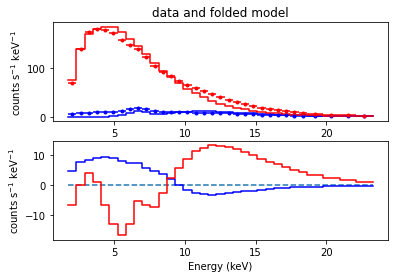

In [7]:
plt.subplot(211)
plt.ylabel(dataLabels[1])
plt.title(dataLabels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.',color='b')
plt.errorbar(energies,rates2,xerr=edeltas,yerr=errors2,fmt='.',color='r')
plt.step(stepenergies,foldedmodel,where='post',color='b')
plt.step(stepenergies,foldedmodel2,where='post',color='r')
plt.subplot(212)
plt.xlabel(residLabels[0])
plt.ylabel(residLabels[1])
plt.step(stepenergies,resid,where='post',color='b')
plt.step(stepenergies,resid2,where='post',color='r')
plt.hlines(0.0,stepenergies[0],stepenergies[-1],linestyles='dashed')

Clearly our assumption that only a change in absorption can account for the spectral variation before and after eclipse is clearly wrong. Perhaps scattering also plays a role in reducing the flux before eclipse. This could be modeled (simply at first) by allowing the normalization of the power law to be smaller before eclipse than after eclipse. To decouple tied parameters, we can change the parameter value in the second group to a value - any value - different from that in the first group (changing the value in the first group has the effect of changing both without decoupling).

In [8]:
m2.powerlaw.norm = 1.0
Fit.perform()


Fit statistic  : Chi-Squared                51448.96     using 33 bins.
                 Chi-Squared              9.949616e+06     using 33 bins.
Total fit statistic                       1.000107e+07     with 59 d.o.f.

Test statistic : Chi-Squared              1.000107e+07     using 66 bins.
 Null hypothesis probability of 0.000000e+00 with 59 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl          1:nH     2:cutoffE       3:foldE    4:PhoIndex        5:norm          6:nH       10:norm
***Warning: Zero alpha-matrix diagonal element for parameter 6
 Parameter 6 is pegged at 1.94492e-08 due to zero or negative pivot element, likely
 caused by the fit being insensitive to the parameter.
28403.7      173861       -3       37.3744       5.67197       8.29470      0.567248     0.0366093   1.94492e-08      0.120893
21282.9      140465       -4       30.9428       5.14085       9.36123      0.510361     0.02

In [9]:
Plot("data resid")
energies = Plot.x()
edeltas = Plot.xErr()
rates = Plot.y(1,1)
errors = Plot.yErr(1,1)
rates2 = Plot.y(2,1)
errors2 = Plot.yErr(2,1)
foldedmodel = Plot.model()
foldedmodel2 = Plot.model(2)
dataLabels = Plot.labels(1)
residLabels = Plot.labels(2)
# note that for matplotlib step plots we need an x-axis array which includes the start and end value for each
# bin and the y-axis has to be the same size with an extra value added equal to the value of the last bin
nE = len(energies)
stepenergies = list()
for i in range(nE):
    stepenergies.append(energies[i] - edeltas[i])
stepenergies.append(energies[-1]+edeltas[-1])
foldedmodel.append(foldedmodel[-1])
foldedmodel2.append(foldedmodel2[-1])
resid = Plot.y(1,2)
resid.append(resid[-1])
resid2 = Plot.y(2,2)
resid2.append(resid2[-1])

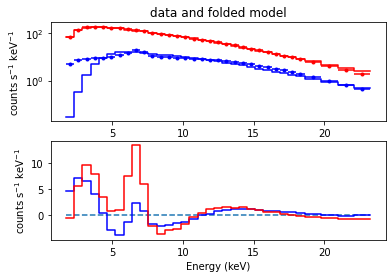

In [10]:
plt.subplot(211)
plt.yscale('log')
plt.ylabel(dataLabels[1])
plt.title(dataLabels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.',color='b')
plt.errorbar(energies,rates2,xerr=edeltas,yerr=errors2,fmt='.',color='r')
plt.step(stepenergies,foldedmodel,where='post',color='b')
plt.step(stepenergies,foldedmodel2,where='post',color='r')
plt.subplot(212)
plt.xlabel(residLabels[0])
plt.ylabel(residLabels[1])
plt.step(stepenergies,resid,where='post',color='b')
plt.step(stepenergies,resid2,where='post',color='r')
plt.hlines(0.0,stepenergies[0],stepenergies[-1],linestyles='dashed')

This decoupling improves the fit, but it still clearly not good. Indeed, this simple attempt to account for the spectral variability in terms of "blanket" cold absorption and scattering does not work. More sophisticated models, involving additional components and partial absorption, should be tried.